# Sending a request to the Applied Climate Information System (ACIS)

ACIS is a system architecture developed, maintained, and operated by the NOAA Regional Climate Centers (RCCs)  
(see their web page [http://www.rcc-acis.org/aboutacis_overview.html](http://www.rcc-acis.org/aboutacis_overview.html) for information). We used the service of the system before to retrieve station climate data. Now we want to make use of a high-resolution (4kmx4km) gridded data product to obtain the cooling degree days (CDD) for the state of New York.


We have developed a function that sends a data request to the server side, and the server returns the gridded data set including the metadata information for the longitude, latitude, and elevation of the grid domain. 


**Acknowledgements:**

The code to request the data from the data server was provided by **Professor DeGaentano** at Cornell University.
Here we modified it to work with the urllib3 library. 

In [1]:
import urllib3
import json
import datetime as dt
import numpy as np

##########################################################################################################
# Do not change the code inside the function definition!
# If you want to experiment with the code and make different data requests,
# make a copy of this code and create a new function definition.
##########################################################################################################
def request_gridded_gdd(year,basetemp,state="NY"):
    """send a data request to the server and retrieve growing degree days data for one year.
    Input paramter:
    \t year \t \t : begin date and end date of type datetime 
    \t basetemp \t : base temperature (e.g. 65 (Fahrenheit) for cooling degree days).
    \t state \t \t : an optional parameter for changing the default state (NY) to another state (e.g. CA)
    Returned objects:
    \t lat, lon, elev, data \t : numpy arrays with latitude (1-dim), longitude (1-dim),
    \t \t \t \t   elevation (2-dim), and data (2-dim) is the returned climate data
    \t \t \t \t  (e.g. cooling degree days)
    """
    # data server's host address
    host="http://grid.rcc-acis.org/GridData"
    # Data identification number ( server side has several gridded data productions, do not change this value)
    grid_num = 21 # 4kmx 4km data set
    
    # future use: allow for regional lat-lon rectangular region 
    #bbox_coords= "-72.50, 42.25,-66.5,40.5" 
    #region=(-72.50,42.25,-66.5,40.5)
    #regionstring="[%f12.4, %f12.4, %f12.4, %f12.4]" % (region[0],region[1],region[2],region[3])
    
    # Entire year could be requested with simply the year 2017 (?) instead 2017-01-01 and 2017-12-31
    sdate_str=str(year)+"-01-01"
    edate_str=str(year)+"-12-31"
    varname="gdd"+str(int(basetemp))
    
    print ("base temperature: "+str(int(basetemp))+"F")
    print ("used in degree day calculation: x= max(tmean[F]-basetemp,0), sum x over all days in year")   
    print ("Variable name : "+varname)
    print ("Start and end date: "+sdate_str+" - "+edate_str)
    input_dict = {"state":state.lower(),"sdate":sdate_str,"edate":edate_str,
                  "grid":"21","elems":[{"name":varname,"interval":"yly","duration":"yly","reduce":"sum"}],
                  "meta":["ll","elev"]}
    # convert into json format for the POST request
    encode_body=json.dumps(input_dict)
    
    # try to connect and to get the requested data
    # in format ready to export to a csv file
    print("#"*80)
    print ("# send data request to "+host)
    print("#"*80)
    try:
        print("post data request "+host+" ... ")
        http= urllib3.PoolManager()
        response = http.request('POST',host,headers={'Content-Type': 'application/json'},body=encode_body)
        content =  response.data.decode('utf-8')
        print ("server responded.")
    except Exception as e:
        print ("error occurred:", e)
        lat,lon,elev,data= None, None, None, None
    # decode the content
    try:
        print("use json.loads() for decoding the content")
        result=json.loads(content)
        meta=result['meta']
        lat=np.array(meta['lat'],dtype=np.float)
        lon=np.array(meta['lon'],dtype=np.float)
        elev=np.array(meta['elev'],dtype=np.float)
        databuffer=result['data']
        data=np.array(databuffer[0][1],dtype=np.float)
    except Exception as e:
        print("error decoding the content with json.loads()")
        print("check values in the returned numpy-arrays!!!")
        print(e)
    return lat,lon,elev,data

def print_summary(x):
    """function that gives a compact summary of the data arry's shape, and data value statistics"""
    print(60*"=")
    print("Dimension (shape) of the array:", np.shape(x))
    print("Data range: min, max: ",np.nanmin(x),np.nanmax(x))
    print("Number of np.NAN in x: ",np.sum(np.isnan(x)))
    print("Mean and Variance: ",np.nanmean(x),np.nanvar(x))
    print(60*"=")
    return

####################################################################################################
# END OF FUNCTION DEFINITIONS
####################################################################################################

In [2]:
####################################################################################################
# calling the data retrieval function
# the first number is the year, the second number
# the base temperature for the CCD calculation
###################################################################################################
lat,lon,elev,data=request_gridded_gdd(2005,(10.*9/5+32))

base temperature: 50F
used in degree day calculation: x= max(tmean[F]-basetemp,0), sum x over all days in year
Variable name : gdd50
Start and end date: 2005-01-01 - 2005-12-31
################################################################################
# send data request to http://grid.rcc-acis.org/GridData
################################################################################
post data request http://grid.rcc-acis.org/GridData ... 
server responded.
use json.loads() for decoding the content


In [3]:
print(type(lat))
print_summary(lat)
print_summary(lon)
print_summary(elev)
print_summary(data)

<class 'numpy.ndarray'>
Dimension (shape) of the array: (111, 192)
Data range: min, max:  40.458333 45.041666
Number of np.NAN in x:  0
Mean and Variance:  42.74999966666667 1.782407398148222
Dimension (shape) of the array: (111, 192)
Data range: min, max:  -79.791667 -71.833333
Number of np.NAN in x:  0
Mean and Variance:  -75.8125 5.333188675926
Dimension (shape) of the array: (111, 192)
Data range: min, max:  -107507.0 4124.0
Number of np.NAN in x:  0
Mean and Variance:  -21314.18656156156 1931499216.0476832
Dimension (shape) of the array: (111, 192)
Data range: min, max:  -999.0 4114.0
Number of np.NAN in x:  0
Mean and Variance:  1827.2730855855855 2212887.684245584


### Replacing dummy values with np.NAN values
The returned data contain dummy values -999. We set them to np.NAN values.  
Elevation (elev, units ft) contains large negative values as dummies. We set those to np.NAN, too.

In [21]:
elev[elev<=-100000]=np.NAN
data[data<=-999]=np.NAN
print_summary(elev)
print_summary(data)

Dimension (shape) of the array: (111, 192)
Data range: min, max:  0.0 4124.0
Number of np.NAN in x:  4397
Mean and Variance:  1091.3588530889742 380781.2913840822
Dimension (shape) of the array: (111, 192)
Data range: min, max:  1356.0 4114.0
Number of np.NAN in x:  4397
Mean and Variance:  2561.953709725096 171957.0465713695


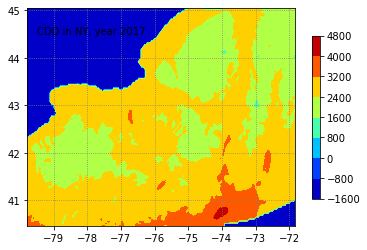

In [5]:
import matplotlib.pyplot as plt

# Try these lines, too. It will plot the elevation.
#plt.pcolormesh(lon, lat, elev,cmap=plt.cm.terrain)
#plt.colorbar(shrink=0.75)

plt.contourf(lon,lat,data,cmap=plt.cm.jet)
plt.colorbar(shrink=0.75)
plt.grid(color='gray',linestyle=':')
plt.text(-79.5,44.5,"CDD in NY, year 2017")
plt.show()


## References:
* [Data server requests](http://www.rcc-acis.org/docs_webservices.html)
* [Matplotlib contour and pcolormesh](https://matplotlib.org/gallery/images_contours_and_fields/pcolormesh_levels.html)
* [Python course contour plot examples](https://www.python-course.eu/matplotlib_contour_plot.php)


    